In [8]:
import os
from base_fns import get_local_folder

os.chdir(os.path.dirname(get_local_folder()))
from script.ct_model import CtTagger
import pandas as pd
import tabulate as tb
from hydra import compose, initialize
from omegaconf import OmegaConf
import random
from munch import Munch
import numpy as np
from pandarallel import pandarallel
from pathlib import Path
from transformers import BertTokenizerFast as BertTokenizer, BertModel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

with initialize(
    version_base=None,
    config_path="../cfg",
):
    cfg = compose(config_name="main")

random.seed(cfg.random.seed)
np.random.seed(cfg.random.seed)

In [3]:
DF_FP = cfg.evaluation.celltriage.oneweek_txt
df = pd.read_csv(DF_FP , sep = "\t")
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,PMID,SCORE_0918,PMCID,ABSTRACT,FULLTEXT,SCORE_0110A,SCORE_0110B,SCORE_0110C
0,0,0,0,37682469,97.26,NaN,"Analysis of Chromatin Accessibility, Histone M...","Analysis of Chromatin Accessibility, Histone M...",21.69,31.86,62.78
1,1,1,1,37663788,97.25,PMC10469926,Improved prediction of MHC-peptide binding usi...,Improved prediction of MHC-peptide binding usi...,0.89,0.18,1.14
2,2,2,2,37662358,97.22,PMC10473580,Active learning of enhancer and silencer regul...,Active learning of enhancer and silencer regul...,1.42,3.30,14.42
3,3,3,3,37669185,97.22,NaN,Experts Collaboration Learning for Continual M...,Experts Collaboration Learning for Continual M...,0.38,0.06,0.54
4,4,4,4,37685874,97.21,PMC10487524,A Leukemic Target with a Thousand Faces: The M...,A Leukemic Target with a Thousand Faces: The M...,1.81,0.93,37.44


##  0918 model
baseline

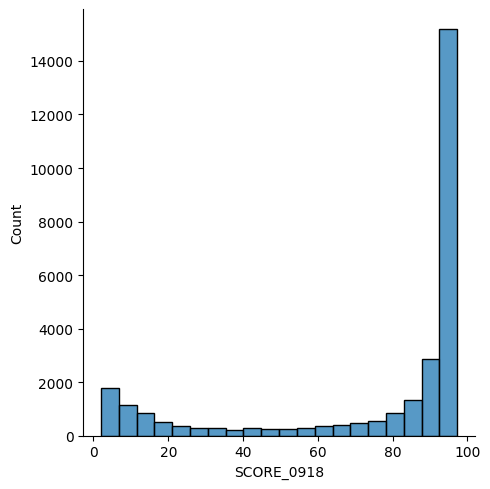

In [39]:
# hist = df["PMID,SCORE_0918"].hist(bins=3)
sns.displot(df['SCORE_0918'],  kde=False, bins=20)

## Model 0110A
silver/ft/pmbert

In [34]:
LABELS = ["PMID"] # Dummy labels, not to be used
MAX_TOKEN_COUNT = cfg.model.max_token_count
TEXT_COL = cfg.model.text_col.fulltext
CHECKPOINT_PATH = cfg.checkpoint.train_silver.fulltext.pmbert
LM_MODEL_NAME = cfg.model.lm.pmbert
tagger = CtTagger(CHECKPOINT_PATH, LABELS, TEXT_COL, LM_MODEL_NAME)
predictions, _ = tagger.predict(df)
y_pred_score = predictions.numpy().flatten()


100%|██████████| 28609/28609 [08:51<00:00, 53.83it/s]


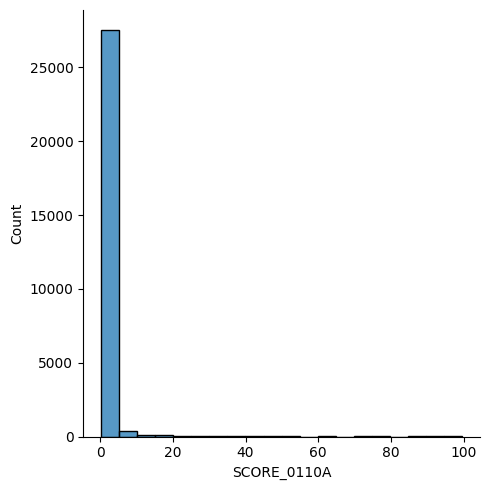

In [38]:
df['SCORE_0110A'] = np.round(y_pred_score*100,2)
sns.displot(df['SCORE_0110A'],  kde=False, bins=20)

## Model 0110B
bronze/ft/pmbert

In [37]:
LABELS = ["PMID"] # Dummy labels, not to be used
MAX_TOKEN_COUNT = cfg.model.max_token_count
TEXT_COL = cfg.model.text_col.fulltext
CHECKPOINT_PATH = cfg.checkpoint.train_bronze.fulltext.pmbert
LM_MODEL_NAME = cfg.model.lm.pmbert
tagger = CtTagger(CHECKPOINT_PATH, LABELS, TEXT_COL, LM_MODEL_NAME)
predictions, _ = tagger.predict(df)
B_pred_score = predictions.numpy().flatten()

100%|██████████| 28609/28609 [09:00<00:00, 52.92it/s]


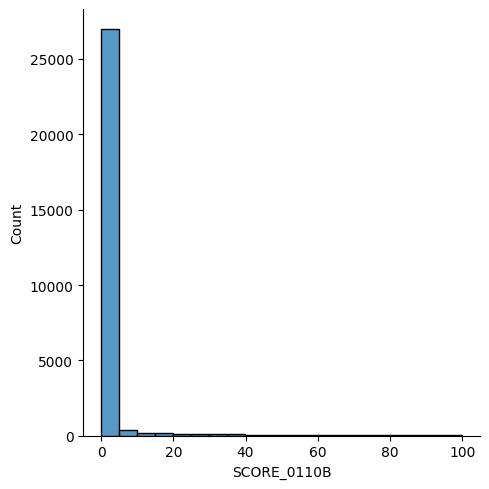

In [40]:
df['SCORE_0110B'] = np.round(B_pred_score*100,2)
sns.displot(df['SCORE_0110B'],  kde=False, bins = 20)

## Model 0110C
ml_abs/ft/pmbert

In [4]:
LABELS = ["PMID"] # Dummy labels, not to be used
MAX_TOKEN_COUNT = cfg.model.max_token_count
TEXT_COL = cfg.model.text_col.fulltext
CHECKPOINT_PATH = cfg.checkpoint.train_ml_ab.fulltext.pmbert
LM_MODEL_NAME = cfg.model.lm.pmbert
tagger = CtTagger(CHECKPOINT_PATH, LABELS, TEXT_COL, LM_MODEL_NAME)
predictions, _ = tagger.predict(df)
C_pred_score = predictions.numpy().flatten()

100%|██████████| 28609/28609 [09:16<00:00, 51.45it/s]


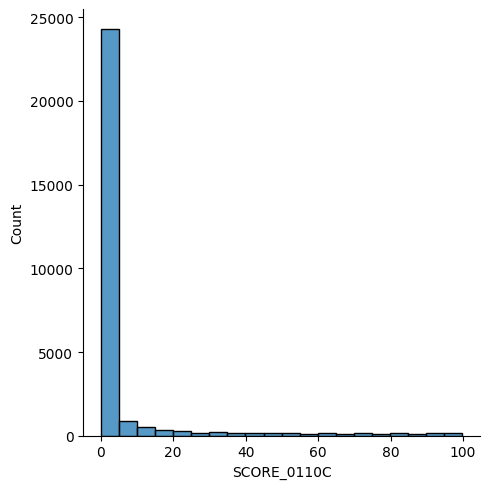

In [5]:
df['SCORE_0110C'] = np.round(C_pred_score*100,2)
sns.displot(df['SCORE_0110C'],  kde=False, bins = 20)

## Model 0110D
bronze_abs/ft/pmbert

In [4]:
LABELS = ["PMID"] # Dummy labels, not to be used
MAX_TOKEN_COUNT = cfg.model.max_token_count
TEXT_COL = cfg.model.text_col.fulltext
CHECKPOINT_PATH = cfg.checkpoint.train_bronze_ab.fulltext.pmbert
LM_MODEL_NAME = cfg.model.lm.pmbert
tagger = CtTagger(CHECKPOINT_PATH, LABELS, TEXT_COL, LM_MODEL_NAME)
predictions, _ = tagger.predict(df)
D_pred_score = predictions.numpy().flatten()

100%|██████████| 28609/28609 [09:15<00:00, 51.53it/s]


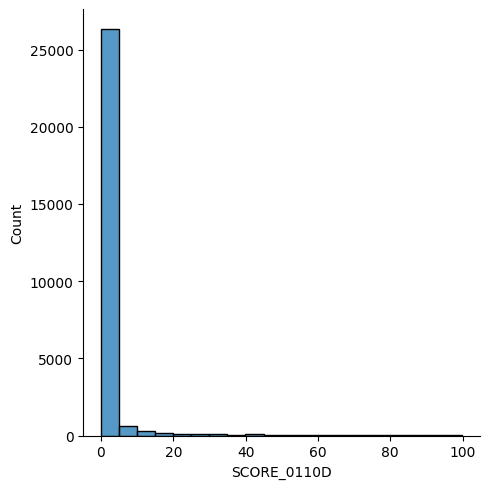

In [6]:
df['SCORE_0110D'] = np.round(D_pred_score*100,2)
sns.displot(df['SCORE_0110D'],  kde=False, bins = 20)

Write Results

In [9]:
FP_0110A = cfg.evaluation.celltriage.oneweek_0110A
df_0110A = df[["PMID", "SCORE_0110A"]].sort_values(by=['SCORE_0110A'], ascending=False)
df_0110A.to_csv(FP_0110A,sep='\t')

FP_0110B = cfg.evaluation.celltriage.oneweek_0110B
df_0110B = df[["PMID", "SCORE_0110B"]].sort_values(by=['SCORE_0110B'], ascending=False)
df_0110B.to_csv(FP_0110B,sep='\t')

FP_0110C = cfg.evaluation.celltriage.oneweek_0110C
df_0110C = df[["PMID", "SCORE_0110C"]].sort_values(by=['SCORE_0110C'], ascending=False)
df_0110C.to_csv(FP_0110C,sep='\t')

FP_0110D = cfg.evaluation.celltriage.oneweek_0110D
df_0110D = df[["PMID", "SCORE_0110D"]].sort_values(by=['SCORE_0110D'], ascending=False)
df_0110D.to_csv(FP_0110D,sep='\t')

df.to_csv(DF_FP,sep='\t')